### TODOs

- Configure as trainable files with different parameters
- Make it trainable with another datasets easily(Face Generation?)
- Generate result images and loss graphs(tensorboard can be used)

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms

# TODO: might be unnecessary due dataloader transforms, check
composed_transforms = transforms.Compose([
    transforms.ToTensor(), # performs scaling by default for image datasets between range(0-1)
])

train_val_set = MNIST("../MNIST/train", train=True, transform=composed_transforms, download=True)
test_set = MNIST("../MNIST/test", train=False, transform=composed_transforms, download=True)

train_set, val_set = torch.utils.data.random_split(dataset=train_val_set, lengths=[.9, .1])


In [8]:
def get_noise(n_samples: int, noise_dim: int, device:str="cpu"):
    # create normally distributed noise data for generator
    return torch.randn(n_samples, noise_dim, device=device)


In [48]:
import os

def save_model(model:nn.Module, epochs: int, base_path: str, name: str):
    torch.save(model, os.path.join(base_path, f"{name}_{epochs}.pth"))

In [17]:
from torch import nn


class Generator(nn.Module):
    """
    Deep Convolutional GAN generator class, TBD
    """

    def __init__(self, noise_dim=10, image_channel=1, hidden_dim=64) -> None:
        super().__init__()
        self.noise_dim = noise_dim
        self.image_channel = image_channel
        # Building the generator block of the network

        self.gen = nn.Sequential(
            self.generator_block(self.noise_dim, hidden_dim * 4),
            self.generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.generator_block(hidden_dim * 2, hidden_dim),
            self.generator_block(hidden_dim, self.image_channel, kernel_size=4, final_layer=True),
        )

    def generator_block(
        self,
        input_channels,
        output_channels,
        kernel_size=3,
        stride=2,
        final_layer=False,
    ):
        # Conditional return according to the layer type
        return (
            nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
            if not final_layer
            else nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )
        )

    def unsqueeze_noise_vector(self, noise):
        """
        Reshaping noise vector by using .view to be compatible with model shapes
        """
        return noise.view(len(noise), self.noise_dim, 1, 1)
    
    
    def forward(self, noise): 
        """
        Forward propagation of network
        Parameters:
            noise: a noise tensor with dimensions (n_samples, noise_dim)
        """
        return self.gen(self.unsqueeze_noise_vector(noise))
    

In [26]:
class Discriminator(nn.Module):
    
    def __init__(self, image_channel=1, hidden_dim=16):
        super().__init__()
        self.discriminator = nn.Sequential(
            self.discriminator_block(image_channel, hidden_dim),
            self.discriminator_block(hidden_dim, hidden_dim*2),
            self.discriminator_block(hidden_dim*2, 1, final_layer=True),
        )
    
    def discriminator_block(
        self, 
        input_dim, 
        output_dim, 
        kernel_size=4,
        stride=2,
        final_layer=False,
    ):
        return (
            nn.Sequential(
                nn.Conv2d(input_dim,output_dim, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_dim),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)   
            )    
            if not final_layer
            else nn.Sequential(
                nn.Conv2d(input_dim, output_dim, kernel_size=kernel_size, stride=stride)
            )
        )
    
    def forward(self, image):
        disc_pred = self.discriminator(image)
        return disc_pred.view(len(disc_pred), -1)
    
    

In [35]:
# binary cross entropy with Sigmoid, uses raw logits, way more stable than using Sigmoid in image
criterion = nn.BCEWithLogitsLoss()
noise_dimension = 64
print_every = 500
batch_size = 128

# Learning rate of 0.0002 works well on DCGAN
learning_rate = 0.0002

# Adam optimizer beta values
beta_1 = 0.5 
beta_2 = 0.999

# device
device = 'cuda'

In [34]:
# Scale mnist data values between -1 and 1 for tanh compatibility
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataloader = DataLoader(
    train_set,   
    batch_size=batch_size,
    shuffle=True
)

validation_dataloader = DataLoader(
    val_set,   
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(
    test_set,   
    batch_size=batch_size,
    shuffle=True
)

In [42]:
# image channel as 1 for MNIST
gen = Generator(noise_dim=noise_dimension, image_channel=1).to(device)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(beta_1, beta_2))

# image channel as 1 for MNIST
disc = Discriminator(image_channel=1).to(device)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(beta_1, beta_2))


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [43]:

import matplotlib.pyplot as plt
from torchvision.utils import make_grid


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [61]:
def calculate_generator_loss(discriminator, fake_images, criterion):
    # calculate discriminator prediction for generated fake images
    pred_fake = discriminator(fake_images)
    # calculate generator loss according to discriminator pred for new fake images
    """
    Our y_true value for loss calculation is a bit trivial since as in generator side, 
    our aim is to generate images that discriminator will classify as real ones so our 
    ground_truth values are all ones.
    """
    generator_loss = criterion(pred_fake, torch.ones_like(pred_fake))
    return generator_loss

In [60]:
def calculate_discriminator_loss(discriminator, fake_images, real_images, criterion, device):
    pred_fake = discriminator(fake_images)
    # they are fake, so y_true should be all zeros and same shape with pred_fake
    loss_fake = criterion(pred_fake, torch.zeros_like(pred_fake))
    
    pred_real = discriminator(real_images)
    # they are real, so y_true should be all ones and same shape with pred_real
    loss_real = criterion(pred_real, torch.ones_like(pred_real))
    
    # return average of them
    return (loss_real + loss_fake) / 2

In [ ]:
from tqdm import tqdm

n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real_images, _ in tqdm(train_dataloader):
        # get batch size
        batch_size = real_images.shape[0]

        #  reshape from (batch_size, channel, height, width) to (batch_size, channel*height*width)
        real_images = real_images.reshape(batch_size, -1).to(device)
        
        # Discriminator Part 
        # zero grad before gradient calculations
        disc_optimizer.zero_grad()
        # get random noise data
        noise = get_noise(batch_size, noise_dimension, device)
        fake_images = gen(noise).detach()
        # calculating discriminator loss
        discriminator_loss = calculate_discriminator_loss(disc, fake_images, real_images, criterion, device)
        # Keep track of the average discriminator loss
        mean_discriminator_loss += discriminator_loss.item() / print_every
        
        # calculate discriminator gradients according to both fake and real images together 
        """
        We have detached generator output which removed it from computational graph
        for autograd to calculate gradients chained forward pass like:
            fake = Generator(noise) -> output = Discriminator(fake) = Discriminator(Generator(noise))
        We only calculate Discrimator loss, generator only used for passing a fake image to discriminator
        """
        discriminator_loss.backward(retain_graph=True)
        # updating the parameters of discriminator
        disc_optimizer.step()
        

        
        # Generator Part
        # zero grad before gradient calculations
        gen_optimizer.zero_grad()
        # generate new noise for generator
        noise_new = get_noise(batch_size, noise_dimension, device)
        # generate new fake images for generator step
        fake_images_new = gen(noise_new)
        # calculating generator loss using discriminator output
        generator_loss = calculate_generator_loss(disc, fake_images_new, criterion)
        # calculate generator gradients using disc. retained graph and prev. loss calculation
        generator_loss.backward()
        # updating the parameters of generator
        gen_optimizer.step()

        # Keep track of the average generator loss
        mean_generator_loss += generator_loss.item() / print_every

        ## Visualization code ##
        if cur_step % print_every == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake_images)
            show_tensor_images(real_images)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

In [62]:
save_model(gen, 50, "./models", "dcgan_model_gen")

In [63]:
save_model(disc, 50, "./models", "dcgan_model_disc")

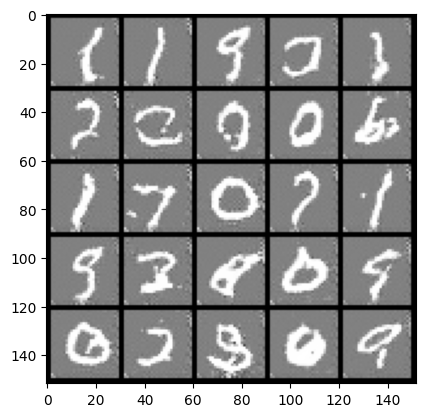

In [64]:
show_tensor_images(gen(get_noise(25, noise_dimension).to(device)))